In [1]:
# Data Imports
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import preprocessing
from tqdm import tqdm
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


# Project Pipeline visualization

![Alt text](./pipeline.png)

# Load Data
In this notebook we use a dataset composed of joint positions from three different pickleball swings: forehand, backhand, and serve, as well as 'neutral' to indicate when the player is stationary or not chasing the ball. 

In [2]:
PICKLEBALL_FOLDER = './pickleball_shots'
BASE_MODEL_PATH = './model_training/primary_tennis_model.h5'
OUT_MODEL_PATH = './model_training/primary_pickleball_model.h5'

X=[]
y=[]

folders = ["initial_shots", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10",
             "13", "14", "16", "17", "18", "19", "20", "21", "22",
              "23", "24", "25", "25", "26", "27" "28"]

for folder in folders:
    if not os.path.exists(f"pickleball_shots/{folder}/shots/"):
        print(f"pickleball_shots/{folder}/shots/ doesnt exist")
        continue
        
    print(f"Loading shots from pickleball/{folder}/shots/")
        
    for shot_csv in tqdm(sorted(os.listdir(f'pickleball_shots/{folder}/shots/'))):
        data = pd.read_csv(os.path.join(f'pickleball_shots/{folder}/shots/', shot_csv))
        
        if folder == "nadal":
            revert_data= data.copy()
            for feature in data.columns:
                if feature[-2:]=="_x":
                    revert_data[feature] = 1 - data[feature]
            data = revert_data

        features = data.loc[:, data.columns != 'shot']

        X.append(features.to_numpy())
        y.append(data["shot"].iloc[0])
    
X = np.stack(X, axis=0)

y = np.array(y)
X = np.array(X)

print(f"Loaded {len(y)} shots for training")

pickleball_shots/initial_shots/shots/ doesnt exist
Loading shots from pickleball/1/shots/


100%|██████████| 7/7 [00:00<00:00, 139.37it/s]


Loading shots from pickleball/2/shots/


100%|██████████| 4/4 [00:00<00:00, 362.69it/s]


Loading shots from pickleball/3/shots/


100%|██████████| 14/14 [00:00<00:00, 317.95it/s]


Loading shots from pickleball/4/shots/


100%|██████████| 4/4 [00:00<00:00, 399.88it/s]


Loading shots from pickleball/5/shots/


100%|██████████| 15/15 [00:00<00:00, 245.90it/s]


pickleball_shots/6/shots/ doesnt exist
Loading shots from pickleball/7/shots/


100%|██████████| 9/9 [00:00<00:00, 128.57it/s]


Loading shots from pickleball/8/shots/


100%|██████████| 5/5 [00:00<00:00, 217.40it/s]


Loading shots from pickleball/9/shots/


100%|██████████| 13/13 [00:00<00:00, 260.00it/s]


Loading shots from pickleball/10/shots/


100%|██████████| 9/9 [00:00<00:00, 409.13it/s]


Loading shots from pickleball/13/shots/


100%|██████████| 24/24 [00:00<00:00, 419.85it/s]


Loading shots from pickleball/14/shots/


100%|██████████| 6/6 [00:00<00:00, 352.32it/s]


Loading shots from pickleball/16/shots/


100%|██████████| 9/9 [00:00<00:00, 428.66it/s]


Loading shots from pickleball/17/shots/


100%|██████████| 3/3 [00:00<00:00, 426.52it/s]


Loading shots from pickleball/18/shots/


100%|██████████| 5/5 [00:00<00:00, 415.79it/s]


Loading shots from pickleball/19/shots/


100%|██████████| 2/2 [00:00<00:00, 397.47it/s]


Loading shots from pickleball/20/shots/


100%|██████████| 25/25 [00:00<00:00, 414.49it/s]


Loading shots from pickleball/21/shots/


100%|██████████| 5/5 [00:00<00:00, 383.89it/s]


Loading shots from pickleball/22/shots/


100%|██████████| 30/30 [00:00<00:00, 440.99it/s]


Loading shots from pickleball/23/shots/


100%|██████████| 31/31 [00:00<00:00, 454.18it/s]


Loading shots from pickleball/24/shots/


100%|██████████| 24/24 [00:00<00:00, 291.66it/s]


Loading shots from pickleball/25/shots/


100%|██████████| 3/3 [00:00<00:00, 333.31it/s]


Loading shots from pickleball/25/shots/


100%|██████████| 3/3 [00:00<00:00, 428.98it/s]


Loading shots from pickleball/26/shots/


100%|██████████| 6/6 [00:00<00:00, 352.48it/s]

pickleball_shots/2728/shots/ doesnt exist
Loaded 256 shots for training


In [3]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)


print(f"Shape of train features : {X_train[0].shape}")
print(f"Shape of val features : {X_val[0].shape}")

print("Total categories: ", len(np.unique(y_train)))
print("Total categories: ", len(np.unique(y_val)))

nb_cat = len(np.unique(y_train))

Shape of train features : (30, 26)
Shape of val features : (30, 26)
Total categories:  4
Total categories:  4


In [4]:
# Encode Labels
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=nb_cat)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=nb_cat)

y_train = np.array(y_train)
X_train = np.array(X_train)

y_val = np.array(y_val)
X_val = np.array(X_val)

In [5]:
assert len(le.classes_) == nb_cat

In [14]:
print("X_train Shape: ", X_train.shape)
print("X_val Shape: ", X_val.shape)
print("y_train Shape: ", y_train.shape)
print("y_val Shape: ", y_val.shape)

X_train Shape:  (204, 30, 26)
X_val Shape:  (52, 30, 26)
y_train Shape:  (204, 4)
y_val Shape:  (52, 4)


# Train model on Pickleball Data

In [6]:
def build_flatten_dense_model(input_shape, num_classes, dropout=0.4):
    inp = Input(shape=input_shape)              
    x = Flatten()(inp)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [19]:
model = build_flatten_dense_model(X_train.shape[1:], nb_cat)
model.summary()

history = model.fit(X_train, y_train,
          validation_split=0.2,
          epochs=200)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30, 26)]          0         
                                                                 
 flatten_4 (Flatten)         (None, 780)               0         
                                                                 
 dense_16 (Dense)            (None, 512)               399872    
                                                                 
 batch_normalization_8 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 256)               131328    
                                                           

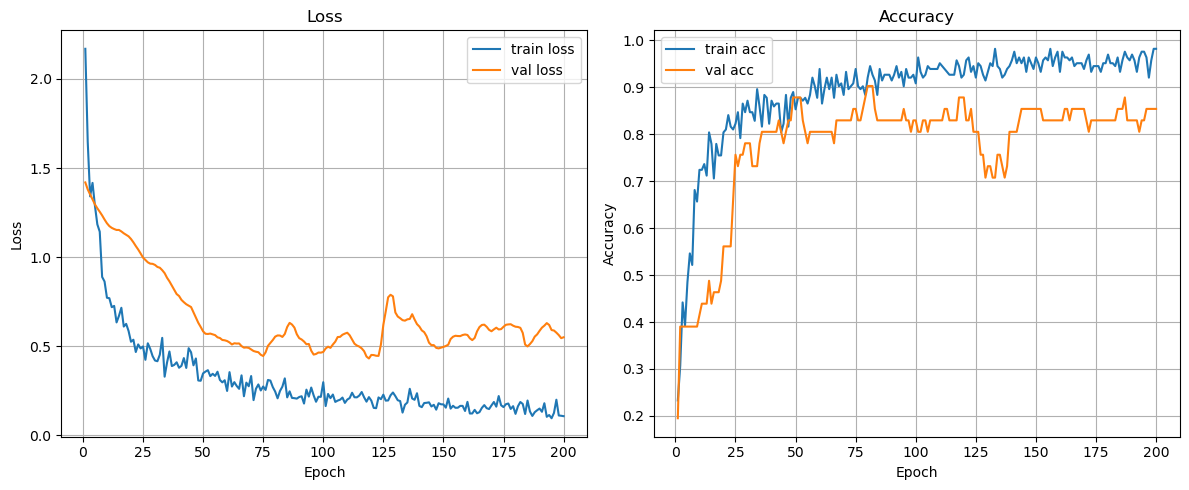

2/2 [==============================] - 0s 7ms/step - loss: 0.2628 - accuracy: 0.8846


[0.2627696990966797, 0.8846153616905212]

In [18]:
def plot_training_history(history, figsize=(12, 5)):
    """
    Plot training & validation loss and accuracy from a Keras `history` (History object or dict).
    Usage: plot_training_history(history)
    """
    # Accept either Keras History object or plain dict
    hist = history.history if hasattr(history, "history") else history
    if not hist or "loss" not in hist:
        raise ValueError("Provided `history` has no 'loss' data. Pass the History returned by model.fit.")

    # detect accuracy keys (TF/Keras versions differ)
    acc_key = "accuracy" if "accuracy" in hist else ("acc" if "acc" in hist else None)
    val_acc_key = "val_accuracy" if "val_accuracy" in hist else ("val_acc" if "val_acc" in hist else None)

    epochs = range(1, len(hist["loss"]) + 1)

    plt.figure(figsize=figsize)

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist.get("loss", []), label="train loss")
    if "val_loss" in hist:
        plt.plot(epochs, hist["val_loss"], label="val loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Accuracy (if available)
    plt.subplot(1, 2, 2)
    if acc_key is not None or val_acc_key is not None:
        if acc_key is not None:
            plt.plot(epochs, hist.get(acc_key, []), label="train acc")
        if val_acc_key is not None:
            plt.plot(epochs, hist.get(val_acc_key, []), label="val acc")
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.legend()
    else:
        plt.text(0.5, 0.5, "No accuracy data in history", ha="center", va="center")
        plt.title("Accuracy (not available)")

    plt.tight_layout()
    plt.show()

# Example:
plot_training_history(history)
model.evaluate(X_val, y_val)

2/2 [==============================] - 0s 3ms/step


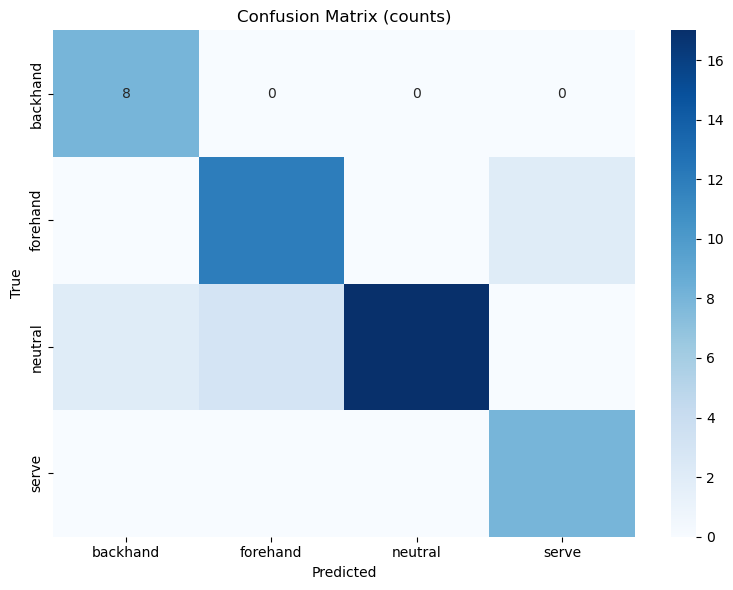

Classification Report:
               precision    recall  f1-score   support

    backhand     0.8000    1.0000    0.8889         8
    forehand     0.8000    0.8571    0.8276        14
     neutral     1.0000    0.7727    0.8718        22
       serve     0.8000    1.0000    0.8889         8

    accuracy                         0.8654        52
   macro avg     0.8500    0.9075    0.8693        52
weighted avg     0.8846    0.8654    0.8652        52

Per-class precision: [0.8 0.8 1.  0.8]
Per-class recall:    [1.     0.8571 0.7727 1.    ]
Per-class f1:        [0.8889 0.8276 0.8718 0.8889]
Support:             [ 8 14 22  8]

Macro avg -> precision: 0.8500, recall: 0.9075, f1: 0.8693
Weighted avg -> precision: 0.8846, recall: 0.8654, f1: 0.8652


In [20]:
# Evaluation: confusion matrix + precision, recall, F1
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

# Get predicted class indices and true class indices
y_true_idx = np.argmax(y_val, axis=1)
y_pred_proba = model.predict(X_val)
y_pred_idx = np.argmax(y_pred_proba, axis=1)

# Map indices to original label names if a fitted LabelEncoder 'le' exists
if 'le' in globals() and hasattr(le, 'classes_'):
    labels = list(le.classes_)
    y_true = le.inverse_transform(y_true_idx)
    y_pred = le.inverse_transform(y_pred_idx)
    cm = confusion_matrix(y_true_idx, y_pred_idx)  # still use indices for the matrix
else:
    # fallback: use numeric class indices as labels
    labels = [str(i) for i in range(y_pred_idx.max() + 1)]
    y_true = y_true_idx
    y_pred = y_pred_idx
    cm = confusion_matrix(y_true_idx, y_pred_idx)

# Plot confusion matrix (counts)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (counts)')
plt.tight_layout()
plt.show()

# Print classification report (precision, recall, f1 per class + averages)
# If labels are strings we can pass them to classification_report's target_names
if isinstance(labels[0], str):
    # classification_report expects integer y_true/y_pred when target_names provided,
    # so pass indices for y_true/y_pred and target_names=labels
    report = classification_report(y_true_idx, y_pred_idx, target_names=labels, digits=4)
else:
    report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:\n", report)

# 5) Also show precision/recall/f1 arrays and macro/weighted averages
p_perclass, r_perclass, f1_perclass, support = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average=None, zero_division=0
)
p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average='macro', zero_division=0
)
p_weighted, r_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average='weighted', zero_division=0
)

print("Per-class precision:", np.round(p_perclass, 4))
print("Per-class recall:   ", np.round(r_perclass, 4))
print("Per-class f1:       ", np.round(f1_perclass, 4))
print("Support:            ", support)
print()
print(f"Macro avg -> precision: {p_macro:.4f}, recall: {r_macro:.4f}, f1: {f1_macro:.4f}")
print(f"Weighted avg -> precision: {p_weighted:.4f}, recall: {r_weighted:.4f}, f1: {f1_weighted:.4f}")

## Interpretation of results
This confusion matrix shows that our model classifies well each category.

# Attempting Tennis Model Finetune

Load our previously trained  `primary_tennis_model.h5` file, leaving weights unfrozen to fine-tune. 

In [21]:
model = load_model(BASE_MODEL_PATH)
print("Loaded base model:")
print(model.input_shape)
model.summary()


Loaded base model:
(None, 30, 26)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 30, 32)            7552      
                                                                 
 batch_normalization_9 (Batc  (None, 30, 32)           128       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 30, 32)            0         
                                                                 
 lstm_8 (LSTM)               (None, 24)                5472      
                                                                 
 batch_normalization_10 (Bat  (None, 24)               96        
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout

In [22]:
# # Freeze early layers (this adjusts how many layers we freeze)
# for layer in model.layers[:-4]:
#     layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.evaluate(X_val, y_val)

2/2 [==============================] - 2s 12ms/step - loss: 1.0299 - accuracy: 0.7692


[1.0298923254013062, 0.7692307829856873]

In [26]:
#Training / callbacks
ckpt = ModelCheckpoint(OUT_MODEL_PATH, save_best_only=True, monitor='val_loss', verbose=1)
es = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=200,
                    callbacks=[ckpt, es],
                    verbose=1)

Epoch 1/200
4/6 [===================>..........] - ETA: 0s - loss: 0.8669 - accuracy: 0.7969
Epoch 1: val_loss improved from inf to 0.76392, saving model to ./model_training\primary_pickleball_model.h5
6/6 [==============================] - 0s 60ms/step - loss: 0.9302 - accuracy: 0.7853 - val_loss: 0.7639 - val_accuracy: 0.8293
Epoch 2/200
6/6 [==============================] - ETA: 0s - loss: 1.0050 - accuracy: 0.7791
Epoch 2: val_loss improved from 0.76392 to 0.75949, saving model to ./model_training\primary_pickleball_model.h5
6/6 [==============================] - 0s 41ms/step - loss: 1.0050 - accuracy: 0.7791 - val_loss: 0.7595 - val_accuracy: 0.8293
Epoch 3/200
6/6 [==============================] - ETA: 0s - loss: 0.9851 - accuracy: 0.7853
Epoch 3: val_loss improved from 0.75949 to 0.75754, saving model to ./model_training\primary_pickleball_model.h5
6/6 [==============================] - 0s 41ms/step - loss: 0.9851 - accuracy: 0.7853 - val_loss: 0.7575 - val_accuracy: 0.8293
Ep

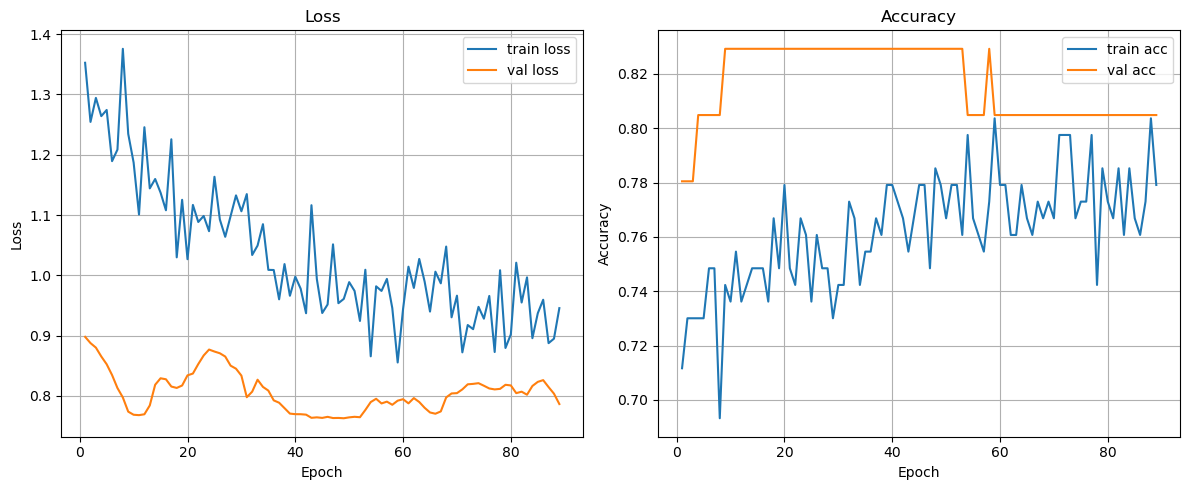

2/2 [==============================] - 0s 8ms/step - loss: 0.6991 - accuracy: 0.8269


[0.6990664601325989, 0.8269230723381042]

In [24]:
plot_training_history(history)
model.evaluate(X_val, y_val)

2/2 [==============================] - 1s 11ms/step


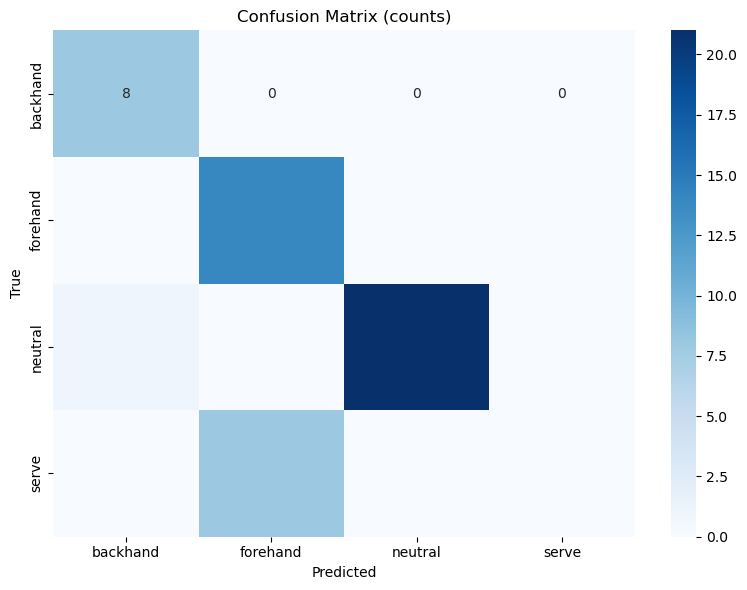


Classification Report:
               precision    recall  f1-score   support

    backhand     0.8889    1.0000    0.9412         8
    forehand     0.6364    1.0000    0.7778        14
     neutral     1.0000    0.9545    0.9767        22
       serve     0.0000    0.0000    0.0000         8

    accuracy                         0.8269        52
   macro avg     0.6313    0.7386    0.6739        52
weighted avg     0.7312    0.8269    0.7674        52

Per-class precision: [0.8889 0.6364 1.     0.    ]
Per-class recall:    [1.     1.     0.9545 0.    ]
Per-class f1:        [0.9412 0.7778 0.9767 0.    ]
Support:             [ 8 14 22  8]

Macro avg -> precision: 0.6313, recall: 0.7386, f1: 0.6739
Weighted avg -> precision: 0.7312, recall: 0.8269, f1: 0.7674


c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Evaluation: confusion matrix + precision, recall, F1
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

# Convert one-hot to class indices
y_true_idx = np.argmax(y_val, axis=1)
y_pred_proba = model.predict(X_val)
y_pred_idx = np.argmax(y_pred_proba, axis=1)


if 'le' in globals() and hasattr(le, 'classes_'):
    labels = list(le.classes_)           # label names in correct index order
else:
    labels = [str(i) for i in range(np.max(y_true_idx) + 1)]

# Confusion matrix using indices
cm = confusion_matrix(y_true_idx, y_pred_idx)

assert cm.shape[0] == len(labels), "Label count does not match confusion matrix shape!"

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,
            fmt='d',          
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (counts)")
plt.tight_layout()
plt.show()

# Classification report
report = classification_report(y_true_idx, y_pred_idx, target_names=labels, digits=4)
print("\nClassification Report:\n", report)

# Precision/recall/F1 details
p_perclass, r_perclass, f1_perclass, support = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average=None, zero_division=0
)

p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average='macro', zero_division=0
)

p_weighted, r_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average='weighted', zero_division=0
)

print("Per-class precision:", np.round(p_perclass, 4))
print("Per-class recall:   ", np.round(r_perclass, 4))
print("Per-class f1:       ", np.round(f1_perclass, 4))
print("Support:            ", support)
print()
print(f"Macro avg -> precision: {p_macro:.4f}, recall: {r_macro:.4f}, f1: {f1_macro:.4f}")
print(f"Weighted avg -> precision: {p_weighted:.4f}, recall: {r_weighted:.4f}, f1: {f1_weighted:.4f}")


# Interpretation
Our finetuned model appears to struggle with discriminating between forehands and serves, which matches with our observations during data collection. Unlike tennis which has very distinct movements for serve and forehand, pickleball players must serve underhand. This motion is challenging to differenciate.